In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

In [2]:
N = 1000
series = np.sin(0.1 * np.arange(N)) + np.random.randn(N) * 0.1

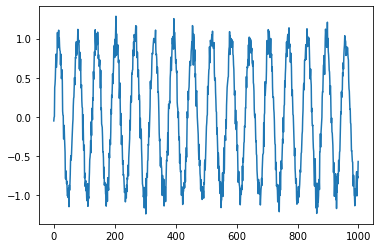

In [3]:
plt.plot(series)

In [4]:
## Build the dataset
# Let's see if we can use T past values to predict the next value
T = 10
X = []
Y = []
for t in range(len(series) - T):
    x = series[t:t + T]
    X.append(x)
    y = series[t+T]
    Y.append(y)
    
X = np.array(X).reshape(-1, T, 1)
Y = np.array(Y).reshape(-1, 1)
N = len(X)
print("X.shape",X.shape, "Y.shape", Y.shape)

X.shape (990, 10, 1) Y.shape (990, 1)


In [5]:
# Set the device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


Define Simple RNN

In [39]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, device):
        super(LSTM, self).__init__()
        self.device = device
        self.params = self.init_params(input_size, hidden_size)
        """
        Inputs:
          input_size: int, feature dimension of input sequence
          hidden_size: int, feature dimension of hidden state
          device: torch.device()
        """
  
    def init_params(self, input_size, hidden_size):
        """
        Inputs:
          input_size: int, feature dimension of input sequence
          hidden_size: int, feature dimension of hidden state

        Outputs:
          Weights for proposal: W_xc, W_hc, b_c
          Weights for input gate: W_xi, W_hi, b_i
          Weights for forget gate: W_xf, W_hf, b_f
          Weights for output gate: W_xo, W_ho, b_o
        """
        W_xc, W_hc, b_c = None, None, None
        W_xi, W_hi, b_i = None, None, None
        W_xf, W_hf, b_f = None, None, None
        W_xo, W_ho, b_o = None, None, None
        ##############################################################################
        # TODO: Initialize the weights and biases. The result will be stored in 
        # `params` below. Weights should be initialized using `torch.randn` multiplied 
        # with the scale (0.1). Biases should be initialized to 0.
        ##############################################################################
        # Replace "pass" statement with your code
        self.hidden_size = hidden_size
        D, M = input_size, hidden_size
        
        W_xc, W_hc, b_c = torch.randn(D,M) * 0.1, torch.randn(M,M) * 0.1, torch.zeros(M,)
        W_xi, W_hi, b_i = torch.randn(D,M) * 0.1, torch.randn(M,M) * 0.1, torch.zeros(M,)
        W_xf, W_hf, b_f = torch.randn(D,M) * 0.1, torch.randn(M,M) * 0.1, torch.zeros(M,)
        W_xo, W_ho, b_o = torch.randn(D,M) * 0.1, torch.randn(M,M) * 0.1, torch.zeros(M,)       
        
        # END OF YOUR CODE

        params = [W_xc, W_hc, b_c, W_xi, W_hi, b_i, W_xf, W_hf, b_f, W_xo, W_ho, b_o]
        return params

  
    def lstm(self, X, state):
        """
        Inputs:
          X: tuple of tensors (src, src_len). src, size (N, D_in) or (N, T, D_in), where N is the batch size,
            T is the length of the sequence(s). src_len, size of (N,), is the valid length for each sequence.

          state: tuple of tensors (h, c). h, size of (N, hidden_size) is the hidden state of LSTM. c, size of 
                (N, hidden_size), is the memory cell of the LSTM.

        Outputs:
          o: tensor of size (N, T, hidden_size).
          state: the same as input state.
        """

        h, c = state

        # make sure always has a T dim

        W_xc, W_hc, b_c, W_xi, W_hi, b_i, W_xf, W_hf, b_f, W_xo, W_ho, b_o = self.params

        o = []
        ##############################################################################
        # TODO: Implement the forward pass of the LSTM.
        ##############################################################################
        # Replace "pass" statement with your code
        o = torch.zeros(X.shape[0], X.shape[1], self.hidden_size)
        for t in range(X.shape[1]):     
            input_gate = torch.sigmoid(X[:,t,:] @ W_xi + h @ W_hi + b_i)
            forget_gate = torch.sigmoid(X[:,t,:] @ W_xf + h @ W_hf + b_f)
            output_gate = torch.sigmoid(X[:,t,:] @ W_xo + h @ W_ho + b_o)
            cell_gate = torch.tanh(X[:,t,:] @ W_xc + h @ W_hc + b_c)
            c = forget_gate * c + input_gate + input_gate * cell_gate
            h = output_gate * torch.tanh(c)
            o[:,t,:] = output_gate
        # END OF YOUR CODE

        state = (h, c)
        return o, state
  
    def forward(self, inputs, state):
        return self.lstm(inputs, state)

In [49]:
# Instantiate the model
hidden_size = 20
model = LSTM(1, hidden_size, device)
model.parameters()

<generator object Module.parameters at 0x00000230A93CAEB0>

In [50]:
# Loss Function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.params, lr=0.1)

In [51]:
# Make inputs and targets
X_train = torch.from_numpy(X[:-N//2].astype(np.float32))
y_train = torch.from_numpy(Y[:-N//2].astype(np.float32))
X_test = torch.from_numpy(X[-N//2:].astype(np.float32))
y_test = torch.from_numpy(Y[-N//2:].astype(np.float32))

In [52]:
X_train[0]

tensor([[-0.0497],
        [-0.0049],
        [ 0.0062],
        [ 0.3761],
        [ 0.4162],
        [ 0.4888],
        [ 0.6543],
        [ 0.8016],
        [ 0.6380],
        [ 0.6351]])

In [53]:
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_train.to(device), y_train.to(device)

In [62]:
# Training
def full_gd(model, criterion, optimizer, X_train, y_train, X_test, y_test, epochs=200):
    # Shuffle to store
    train_losses = np.zeros(epochs)
    test_losses = np.zeros(epochs)
    
    for epoch in range(epochs):
        optimizer.zero_grad()
        h0, c0 = torch.zeros(X_train.shape[0], hidden_size),torch.zeros(X_train.shape[0], hidden_size)
        y_pred, (h0, c0) = model(X_train, (h0, c0))
        print(y_pred[:,-1,:].shape)
        loss = criterion(y_pred[:,-1,:], y_train)
        
        loss.backward()
        optimizer.step()
        
        train_losses[epoch] = loss.item()
        
        test_pred = model(X_test)
        test_loss = criterion(test_pred, y_test)
        test_losses[epoch] = test_loss.item() 
        
        if (epoch + 1) % 5 == 0:
            print(f'Epoch [{epoch + 1}/{epochs}]. Train Loss : {loss.item():.4f}. Test Loss : {test_loss.item():.4f}')
            
    return train_losses, test_losses

In [63]:
train_losses, test_losses = full_gd(model, criterion, optimizer, X_train, y_train, X_test, y_test)

torch.Size([495, 20])


C:\Users\danie\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([495, 1])) that is different to the input size (torch.Size([495, 20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

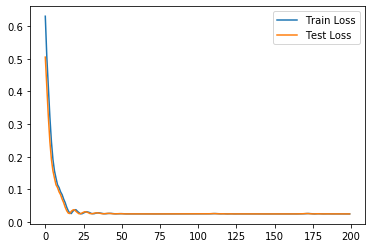

In [46]:
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.legend()
plt.show()

In [47]:
# "Wrong" forecase using true targets
validation_target = Y[-N//2:]
validation_predictions = []

# index of first validation input
i = 0

while len(validation_predictions) < len(validation_target):
    input_ = X_test[i].view(1, T,-1)
    p = model(input_)[0,0].item() # 1x1 array -> scaler
    i += 1
    
    validation_predictions.append(p)

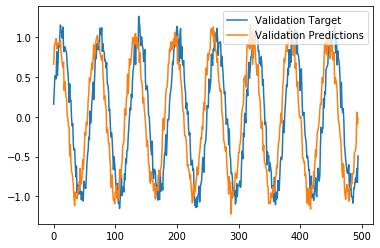

In [48]:
plt.plot(validation_target, label="Validation Target")
plt.plot(validation_predictions, label="Validation Predictions")
plt.legend()
plt.show()

In [49]:
# Forcast future values (use only self-predictions for making future predictions)
validation_target = Y[-N//2:]
validation_predictions = []

# Last Train Input
# 1-D Array of length T
last_x = X_test[0].view(T)

while len(validation_predictions) < len(validation_target):
    input_ = last_x.reshape(1, T, 1)
    p = model(input_)
    
    validation_predictions.append(p[0,0].item())
    
    last_x = torch.cat((last_x[1:], p[0]))

In [50]:
last_x

tensor([0.1548, 0.1548, 0.1548, 0.1548, 0.1548, 0.1548, 0.1548, 0.1548, 0.1548,
        0.1548], device='cuda:0', grad_fn=<CatBackward>)

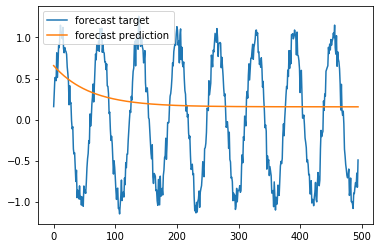

In [51]:
plt.plot(validation_target, label="forecast target")
plt.plot(validation_predictions, label="forecast prediction")
plt.legend()